# Perform VoI calculation using GP surrogate over join action-uncertainty space

In [1]:
import os
import time
import numpy as np
from tqdm import tqdm

from sys_eval import evaluate_system
from schema_builder import build_schema

from scipy.stats import qmc
import sklearn.gaussian_process as gp
import scipy.optimize as op

import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [2]:
ids = [11]

In [3]:
# Define base parameters.
opex_factor = 10
pricing_dict = {'carbon':5e-1,'battery':1e3,'solar':2e3}
base_kwargs = {
    'output_dir_path': os.path.join('data','A37_example_test'),
    'building_names': ['UCam_Building_%s'%id for id in ids],
    'battery_energy_capacities': None,
    'battery_power_capacities': [342.0], # [391.0,342.0,343.0,306.0,598.0,571.0], # from Annex 37
    'battery_efficiencies': None,
    'pv_power_capacities': None,
    'load_data_paths': ['UCam_Building_%s.csv'%id for id in ids],
    'weather_data_path': 'weather.csv',
    'carbon_intensity_data_path': 'carbon_intensity.csv',
    'pricing_data_path': 'pricing.csv',
    'schema_name': 'schema_temp'
}

In [4]:
def construct_and_evaluate_system(battery_capacities,solar_capacities,battery_efficiencies,base_kwargs):

    base_kwargs.update({
                'battery_energy_capacities': battery_capacities,
                'battery_efficiencies': battery_efficiencies,
                'pv_power_capacities': solar_capacities
            })
    schema_path = build_schema(**base_kwargs)

    eval_results = evaluate_system(schema_path,pricing_dict,opex_factor,suppress_output=True)

    return eval_results['objective']

## Step 1: Train GP Surrogate

Note: probably sensible to conduct an initial rough space search to identify sensible bounds as we expect the objective (cost) to be behaviour reasonably nicely, at least far from the region of the optimum.
The smaller the bounded region the better the surrogate will be and the easier the global optimisation will be - however as these bounds are arbitrary, if we encounter boundary solutions, the bounds need to be extended.

Remeber to note Dom's alternative suggestion for learning a surrogate, and it's motivation from the smoothness of his posterior solution results

In [5]:
# Perform sampling of action-uncertainty space
seed = 42
n_samples = 500 # increase for final results

# Space filling sampling of action sub-space using Latin Hypercube
lower_bounds = np.array([*[5e2]*len(ids),*[1e2]*len(ids)])
upper_bounds = np.array([*[2e3]*len(ids),*[1.5e3]*len(ids)])

action_sampler = qmc.LatinHypercube(d=len(ids)*2)
action_samples = action_sampler.random(n=n_samples)
action_samples = qmc.scale(action_samples, lower_bounds, upper_bounds)

# Sample from prior distributions of uncertain parameters
mu = 0.85
sigma = 0.1
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_samples,len(ids)))
eta_samples = np.clip(eta_samples,0,1)

# Combine samples from two sub-spaces
space_samples = np.hstack([action_samples,eta_samples])

In [6]:
# Evaluate system cost over samples.
costs = []

for n in tqdm(range(n_samples)):
    cost = construct_and_evaluate_system(action_samples[n][:len(ids)],action_samples[n][len(ids):],eta_samples[n],base_kwargs)
    costs.append(cost)

100%|██████████| 500/500 [10:23:26<00:00, 74.81s/it] 


In [43]:
# Train Gaussian Process surrogate.

length_scale_init_guess = [*[500]*len(ids),*[100]*len(ids),*[0.1]*len(ids)]
kernel = 1 * gp.kernels.RBF(length_scale=np.array(length_scale_init_guess))
gp_surrogate = gp.GaussianProcessRegressor(kernel=kernel,normalize_y=True, n_restarts_optimizer=5)
gp_surrogate.fit(space_samples, costs)
gp_surrogate.kernel_

0.796**2 * RBF(length_scale=[378, 108, 0.255])

NOTE!!! Training the GP properly seems to be a bit of an issue - the length scales that comes out of the optimiser are sometimes completely off - having a good initialisation to the optimisation seems important

In [44]:
mean_prediction, std_prediction = gp_surrogate.predict(space_samples, return_std=True)

In [45]:
# Visual surrogate model.

# Create set of points in action sub-space to interpolate to
n_predict_points = 1000
action_predict_sampler = qmc.LatinHypercube(d=len(ids)*2)
action_predict_samples = action_predict_sampler.random(n=n_predict_points)
action_predict_samples = qmc.scale(action_predict_samples, lower_bounds, upper_bounds)

# Compute mean cost predicted by surrogate model.
cost_predictions = []

n_MC_samples = 1000
for sample in tqdm(action_predict_samples):
    eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_MC_samples,len(ids)))
    eta_samples = np.clip(eta_samples,0,1)
    predict_points = np.hstack([np.tile(sample,(n_MC_samples,1)),eta_samples])
    mean_prediction = gp_surrogate.predict(predict_points)
    cost_predictions.append(np.mean(mean_prediction))

100%|██████████| 1000/1000 [00:19<00:00, 51.09it/s]


Text(0, 0.5, 'Solar power capacity (kWp)')

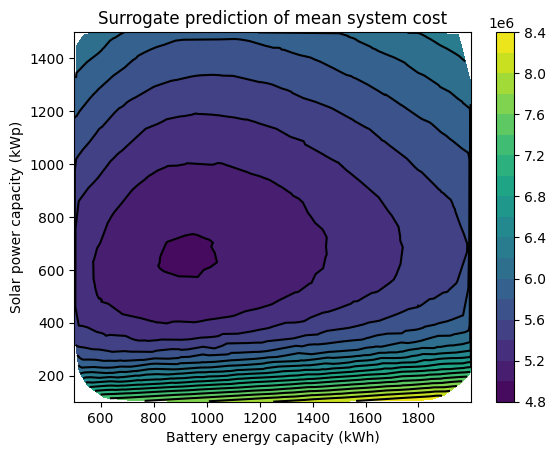

In [46]:
# Plot estatimate mean cost prediction from surrogate.
assert len(ids) == 1

n_levels = 20

fig, ax = plt.subplots()
triang = tri.Triangulation(action_predict_samples[:,0],action_predict_samples[:,1])
tcf = ax.tricontourf(triang,cost_predictions,levels=n_levels)
ax.tricontour(triang, cost_predictions,levels=n_levels, colors='k')
fig.colorbar(tcf)
ax.set_title("Surrogate prediction of mean system cost")
ax.set_xlabel("Battery energy capacity (kWh)")
ax.set_ylabel("Solar power capacity (kWp)")

The lumpier the objective near the true optimum, the worse job the surrogate will do in accurately representing the optimisation. However, this is a feature of the difficultness of the problem, as the global optimisation of the direct MC estimate will also struggle (i.e. require more fevals). The way we deal with this is by adding more sample points to the GP.

Potentially a smarter strategy is to use a mutil-fidelity modelling approach, and refine the bounds on the sampled points iteratively to the subdomain in which the optimal values lie (for likely samples of the uncertain variables), as only this reigon contributes to the computed VoI value.

100%|██████████| 1000/1000 [00:00<00:00, 3691.19it/s]


[0.64174291]


Text(0.5, 1.0, 'Surrogate prediction of system cost for eta=0.6417')

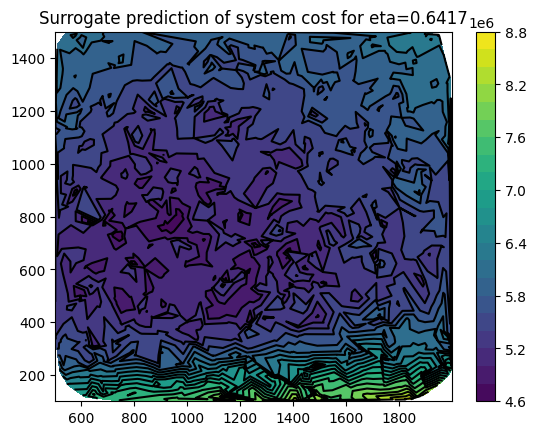

In [47]:
# Compute cost predicted by surrogate model for specific eta.
se_cost_predictions = []

for sample in tqdm(action_predict_samples):
    eta_sample = np.random.normal(loc=mu,scale=sigma,size=(len(ids)))
    predict_points = np.hstack([sample,eta_sample])
    mean_prediction = gp_surrogate.predict([predict_points])
    se_cost_predictions.append(np.mean(mean_prediction))

print(eta_sample)

# Plot estatimate mean cost prediction from surrogate.
assert len(ids) == 1

n_levels = 20

fig, ax = plt.subplots()
triang = tri.Triangulation(action_predict_samples[:,0],action_predict_samples[:,1])
tcf = ax.tricontourf(triang,se_cost_predictions,levels=n_levels)
ax.tricontour(triang, se_cost_predictions,levels=n_levels, colors='k')
fig.colorbar(tcf)
ax.set_title(f"Surrogate prediction of system cost for eta=%s"%round(eta_sample[0],4))

### Investigate convergence of MC estimate using surrogate model

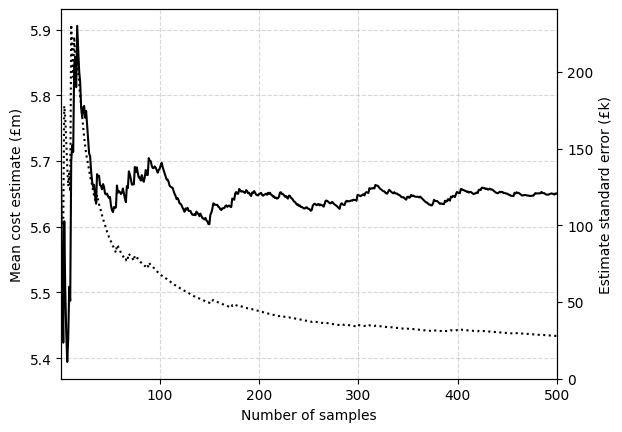

In [48]:
# use last cost_predictions as test case
n_draws = 500

MC_means = [np.mean(cost_predictions[:i]) for i in range(1,n_draws+1)]
MC_stnd_errors = [np.std(cost_predictions[:i])/np.sqrt(i) for i in range(2,n_draws+1)]

fig,ax = plt.subplots()
ax.set_xlim(1,n_draws)
ax.set_xlabel("Number of samples")
ax.grid(True,'major',alpha=0.5,linestyle='--')

ax.plot(range(1,n_draws+1),np.array(MC_means)/1e6,'-k')
ax.set_ylabel('Mean cost estimate (£m)')
#ax.set_ylim(0)

# min_ax = ax.twinx()
# min_ax.plot(range(2,n_draws+1),(np.array(MC_stnd_errors)/MC_means[-1])*100,'k--')
# min_ax.set_ylabel('Estimate standard error (% of final mean)')
# min_ax.set_ylim(0)

min_ax_abs = ax.twinx()
min_ax_abs.plot(range(2,n_draws+1),np.array(MC_stnd_errors)/1e3,'k:')
min_ax_abs.set_ylabel('Estimate standard error (£k)')
min_ax_abs.set_ylim(0)

plt.show()

## Step 2: Solve Prior Problem using Surrogate

In [49]:
# Define fn of mean system cost predicted by surrogate.
def mean_cost_surrogate_estimate(x, surrogate, n_MC_samples, eta_mu, eta_sigma):

    assert len(x) % 2 == 0, "Design variable argument must have even length."

    # Make draw from distribution of uncertainties - specified in args (mu, sigma)
    # ========================================================================
    eta_samples = np.random.normal(loc=eta_mu,scale=eta_sigma,size=(n_MC_samples,len(ids)))
    eta_samples = np.clip(eta_samples,0,1)

    # Predict costs for each efficiency sample at target point using surrogate
    # ========================================================================
    predict_points = np.hstack([np.tile(x,(n_MC_samples,1)),eta_samples])
    mean_prediction = surrogate.predict(predict_points)

    return np.mean(mean_prediction)

In [50]:
bounds = op.Bounds(lb=lower_bounds,ub=upper_bounds)
n_MC_samples = 1000

In [51]:
prior_soln = op.differential_evolution(mean_cost_surrogate_estimate, bounds, args=(gp_surrogate,n_MC_samples,mu,sigma), seed=seed)
print(prior_soln.x, prior_soln.fun, prior_soln.message)
prior_design = prior_soln.x
prior_cost = prior_soln.fun
print(prior_cost)

[948.72556586 653.28642861] 4980466.1404402545 Optimization terminated successfully.
4980466.1404402545


### Test quality of surrogate optimal solution

In [52]:
n_MC_samples = 100
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_MC_samples,len(ids)))
eta_samples = np.clip(eta_samples,0,1)

sample_costs = []

for eta_sample in tqdm(eta_samples):
    sample_cost = construct_and_evaluate_system(prior_design[:len(ids)],prior_design[len(ids):],eta_sample,base_kwargs)
    sample_costs.append(sample_cost)

true_prior_soln_cost_estimate = np.mean(sample_costs)

print(f"Surrogate optimal solution fn error: {round((np.abs(true_prior_soln_cost_estimate-prior_cost)/true_prior_soln_cost_estimate)*100,2)}%")

100%|██████████| 100/100 [2:13:59<00:00, 80.40s/it] 

Surrogate optimal solution fn error: 0.23%


## Step 3: Solve Pre-Posterior Problem using Surrogate

In [54]:
# Sample from prior distribution of uncertainties.
n_prior_samples = 100
prior_eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_prior_samples,len(ids)))
prior_eta_samples = np.clip(prior_eta_samples,0,1)

In [55]:
posterior_sigma = 0.025 # define measurment uncertainty

posterior_optimal_results = []

# Solve posterior problem for each eta sample.
for eta_sample in tqdm(prior_eta_samples):
    posterior_soln = op.differential_evolution(mean_cost_surrogate_estimate, bounds, args=(gp_surrogate,n_MC_samples,eta_sample,posterior_sigma), seed=seed)
    #print(eta_sample, posterior_soln.x, posterior_soln.fun, posterior_soln.message)
    posterior_optimal_results.append(posterior_soln)

preposterior_cost = np.mean([res.fun for res in posterior_optimal_results])
print(preposterior_cost)

100%|██████████| 100/100 [01:30<00:00,  1.11it/s]

4972060.228769584


## Step 4: Report VOI Result

In [56]:
print("VOI: %s"%round(prior_cost-preposterior_cost,2))

VOI: 8405.91


In [57]:
print(prior_cost,preposterior_cost)

4980466.1404402545 4972060.228769584


Could be interesting to plot distribution of posterior optimal solutions alongside distribution of optimised costs.

In [58]:
for res in posterior_optimal_results:
    print(res.x)

[931.47064625 718.36575174]
[926.69038238 696.64154487]
[906.81330449 635.56857786]
[986.20003966 640.30660732]
[922.8467161  630.39606665]
[965.68276325 665.93799842]
[954.81395972 664.44283622]
[920.99652611 617.98916294]
[917.31661491 700.75110592]
[925.11912854 638.42280244]
[917.36836219 624.01375899]
[958.76632238 625.1025426 ]
[949.99536582 676.80530147]
[896.24880472 632.30687438]
[879.77259308 635.95918791]
[921.47752028 640.27723278]
[937.62606418 654.82614072]
[903.43725806 676.40815454]
[902.74429219 634.23355374]
[985.50247461 614.43244311]
[908.28635116 634.93032817]
[979.939027   691.15506997]
[914.16607034 639.09492291]
[917.41502987 637.60309768]
[904.98909064 616.64593247]
[932.29017958 614.43244311]
[925.35444674 614.83702787]
[941.50889929 655.41100737]
[940.89615652 678.10996758]
[911.71718828 666.22125382]
[977.56799454 692.71452326]
[919.39341365 599.63611533]
[918.11247321 605.70323354]
[911.77140084 625.1025426 ]
[887.90702865 641.72849242]
[977.56799454 692.71